In [5]:
import os
import pandas as pd

print(os.getcwd())

print(os.listdir('./data/lahman_1871-2023_csv/'))

file_path = './data/lahman_1871-2023_csv/Pitching.csv'
df = pd.read_csv(file_path)

/Users/jacobgareis/Downloads/DSCI326/DSCI326/Lab1.1
['AwardsManagers.csv', 'Managers.csv', 'AwardsPlayers.csv', 'Fielding.csv', 'Salaries.csv', 'Parks.csv', 'Schools.csv', 'People.csv', 'PitchingPost.csv', 'Teams.csv', 'Appearances.csv', 'AwardsSharePlayers.csv', 'TeamsFranchises.csv', 'Batting.csv', 'ManagersHalf.csv', 'League_Wide_Slugging_PercentageV6.csv', 'FieldingOF.csv', 'Pitching.csv', 'CollegePlaying.csv', 'League_Wide_Slugging_Percentage.csv', 'HomeGames.csv', 'HallOfFame.csv', 'AwardsShareManagers.csv', 'BattingPost.csv', 'League_Wide_Slugging_Percentage_V3.csv', 'TeamsHalf.csv', 'League_Wide_Slugging_Percentage_V2.csv', 'SeriesPost.csv', 'FieldingPost.csv', 'AllstarFull.csv', 'League_Wide_ERA.csv', 'FieldingOFsplit.csv']


In [55]:
import polars as pl

pitching_df = pl.read_csv("./data/lahman_1871-2023_csv/Pitching.csv")
batting_df = pl.read_csv("./data/lahman_1871-2023_csv/Batting.csv")

pitching_df = pitching_df.filter(pl.col('yearID') >= 1946)

grouped_pitching = pitching_df.group_by(['yearID', 'lgID']).agg([
    pl.col('R').sum().alias('Total_Runs_Allowed'),
    pl.col('IPouts').sum().alias('Total_Outs')
])

grouped_pitching = grouped_pitching.with_columns(
    pl.when(
        (pl.col('lgID') == 'AL') & (pl.col('yearID') >= 1973)
    ).then(pl.lit('Yes')).when(
        (pl.col('lgID') == 'NL') & (pl.col('yearID').is_in([2020]) | (pl.col('yearID') >= 2022))
    ).then(pl.lit('Yes')).otherwise(pl.lit('No')).alias('DH_Rule')
)

grouped_pitching = grouped_pitching.with_columns(
    (pl.col('Total_Runs_Allowed') / pl.col('Total_Outs') * 27).alias('ERA')
)

grouped_pitching.write_csv("./data/lahman_1871-2023_csv/League_Wide_ERA.csv")

batting_df = batting_df.filter(pl.col('yearID') >= 1946)

grouped_batting = batting_df.group_by(['yearID', 'lgID']).agg([
    pl.col('H').sum().alias('Total_Hits'),
    pl.col('2B').sum().alias('Total_Doubles'),
    pl.col('3B').sum().alias('Total_Triples'),
    pl.col('HR').sum().alias('Total_Home_Runs'),
    pl.col('AB').sum().alias('Total_At_Bats')
])

grouped_batting = grouped_batting.with_columns(
    pl.when(
        (pl.col('lgID') == 'AL') & (pl.col('yearID') >= 1973)
    ).then(pl.lit('Yes')).when(
        (pl.col('lgID') == 'NL') & (pl.col('yearID').is_in([2020]) | (pl.col('yearID') >= 2022))
    ).then(pl.lit('Yes')).otherwise(pl.lit('No')).alias('DH_Rule')
)

grouped_batting = grouped_batting.with_columns(
    (
        (pl.col('Total_Hits') - pl.col('Total_Doubles') - pl.col('Total_Triples') - pl.col('Total_Home_Runs')) + 
        2 * pl.col('Total_Doubles') + 
        3 * pl.col('Total_Triples') + 
        4 * pl.col('Total_Home_Runs')
    ).alias('Slugging_Percentage') / pl.col('Total_At_Bats')
)

In [57]:
grouped_batting

yearID,lgID,Total_Hits,Total_Doubles,Total_Triples,Total_Home_Runs,Total_At_Bats,DH_Rule,Slugging_Percentage
i64,str,i64,i64,i64,i64,i64,str,f64
1992,"""AL""",20006,3596,386,1776,77147,"""Yes""",0.385005
1997,"""NL""",20300,3907,485,2163,77203,"""No""",0.410165
2000,"""NL""",23594,4632,532,3005,88743,"""No""",0.43164
2008,"""NL""",23071,4729,478,2608,88595,"""No""",0.41289
2010,"""AL""",20131,4016,368,2209,77467,"""Yes""",0.406754
…,…,…,…,…,…,…,…,…
2006,"""AL""",21572,4301,391,2546,78497,"""Yes""",0.43687
2001,"""AL""",20852,4200,440,2506,78134,"""Yes""",0.428111
1978,"""NL""",16556,2861,482,1276,65156,"""No""",0.371554


/var/folders/j2/qlqp3h0134d5kv_75_ffjz380000gn/T/ipykernel_30711/2740974442.py:7: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
/var/folders/j2/qlqp3h0134d5kv_75_ffjz380000gn/T/ipykernel_30711/2740974442.py:32: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


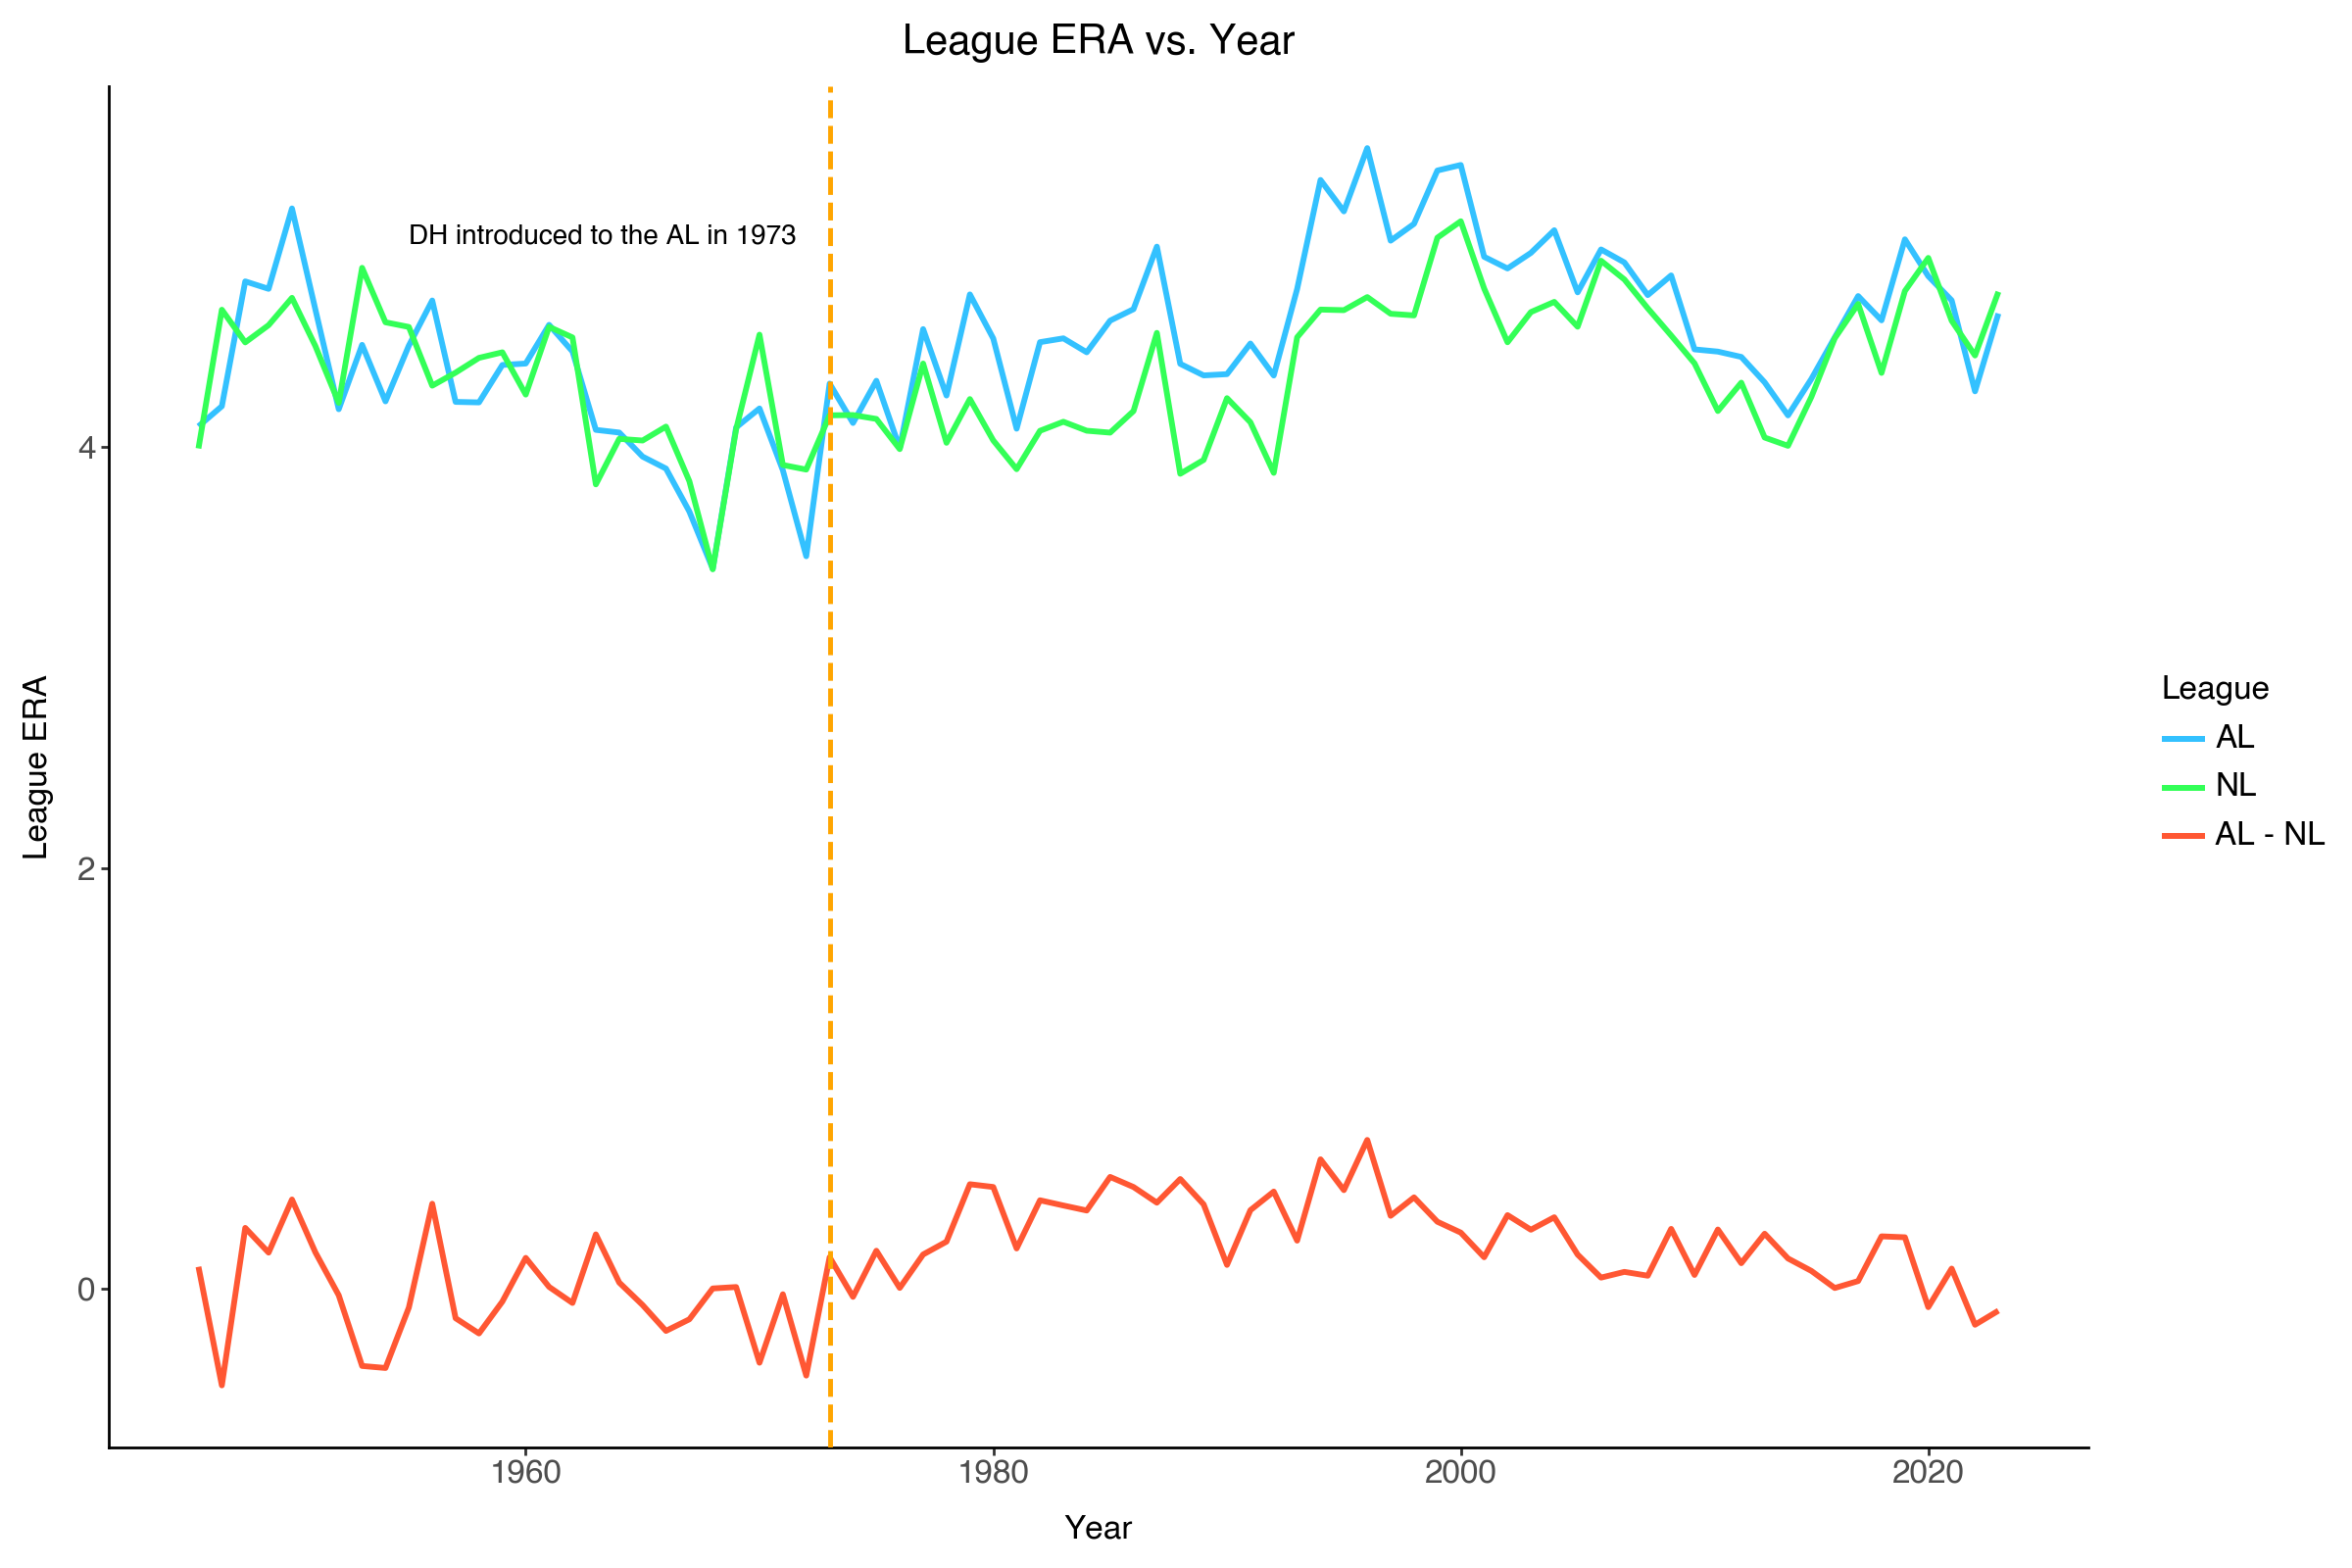

In [69]:
import polars as pl
import pandas as pd
from plotnine import *

era_df = pl.read_csv('./data/lahman_1871-2023_csv/League_Wide_ERA.csv')

era_pivot = era_df.pivot(index='yearID', columns='lgID', values='ERA')

era_pivot = era_pivot.with_columns((pl.col('AL') - pl.col('NL')).alias('AL-NL'))

era_pivot_pd = era_pivot.to_pandas()

era_plot = (ggplot(era_pivot_pd, aes(x='yearID')) +
    geom_line(aes(y='AL', color='"AL"'), size=1.2) +
    geom_line(aes(y='NL', color='"NL"'), size=1.2) +
    geom_line(aes(y='AL-NL', color='"AL-NL"'), size=1.2) +
    scale_color_manual(values={
        'AL': '#33c1ff',
        'NL': '#33ff57',
        'AL-NL': '#ff5733'
    }, labels=["AL", "NL", "AL - NL"]) +
    labs(title='League ERA vs. Year', x='Year', y='League ERA', color='League') +
    geom_vline(xintercept=1973, linetype='dashed', color='orange', size=1) +
    annotate('text', x=1955, y=5, label='DH introduced to the AL in 1973', ha='left', color='black', size=10) +
    theme_classic() +
    theme(legend_position='right', 
          plot_title=element_text(ha='center', size=15),
          text=element_text(size=12)) +
    theme(figure_size=(12, 8))
)

print(era_plot)

In [33]:
print(era_pivot_pd.dtypes)

yearID      int64
NL        float64
AL        float64
AL-NL     float64
dtype: object


In [71]:
era_plot.save('comparing_league_wide_ERA.png', width=10, height=5, dpi=300)

/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 10 x 5 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: comparing_league_wide_ERA.png


/var/folders/j2/qlqp3h0134d5kv_75_ffjz380000gn/T/ipykernel_30711/2282407828.py:6: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
/var/folders/j2/qlqp3h0134d5kv_75_ffjz380000gn/T/ipykernel_30711/2282407828.py:31: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


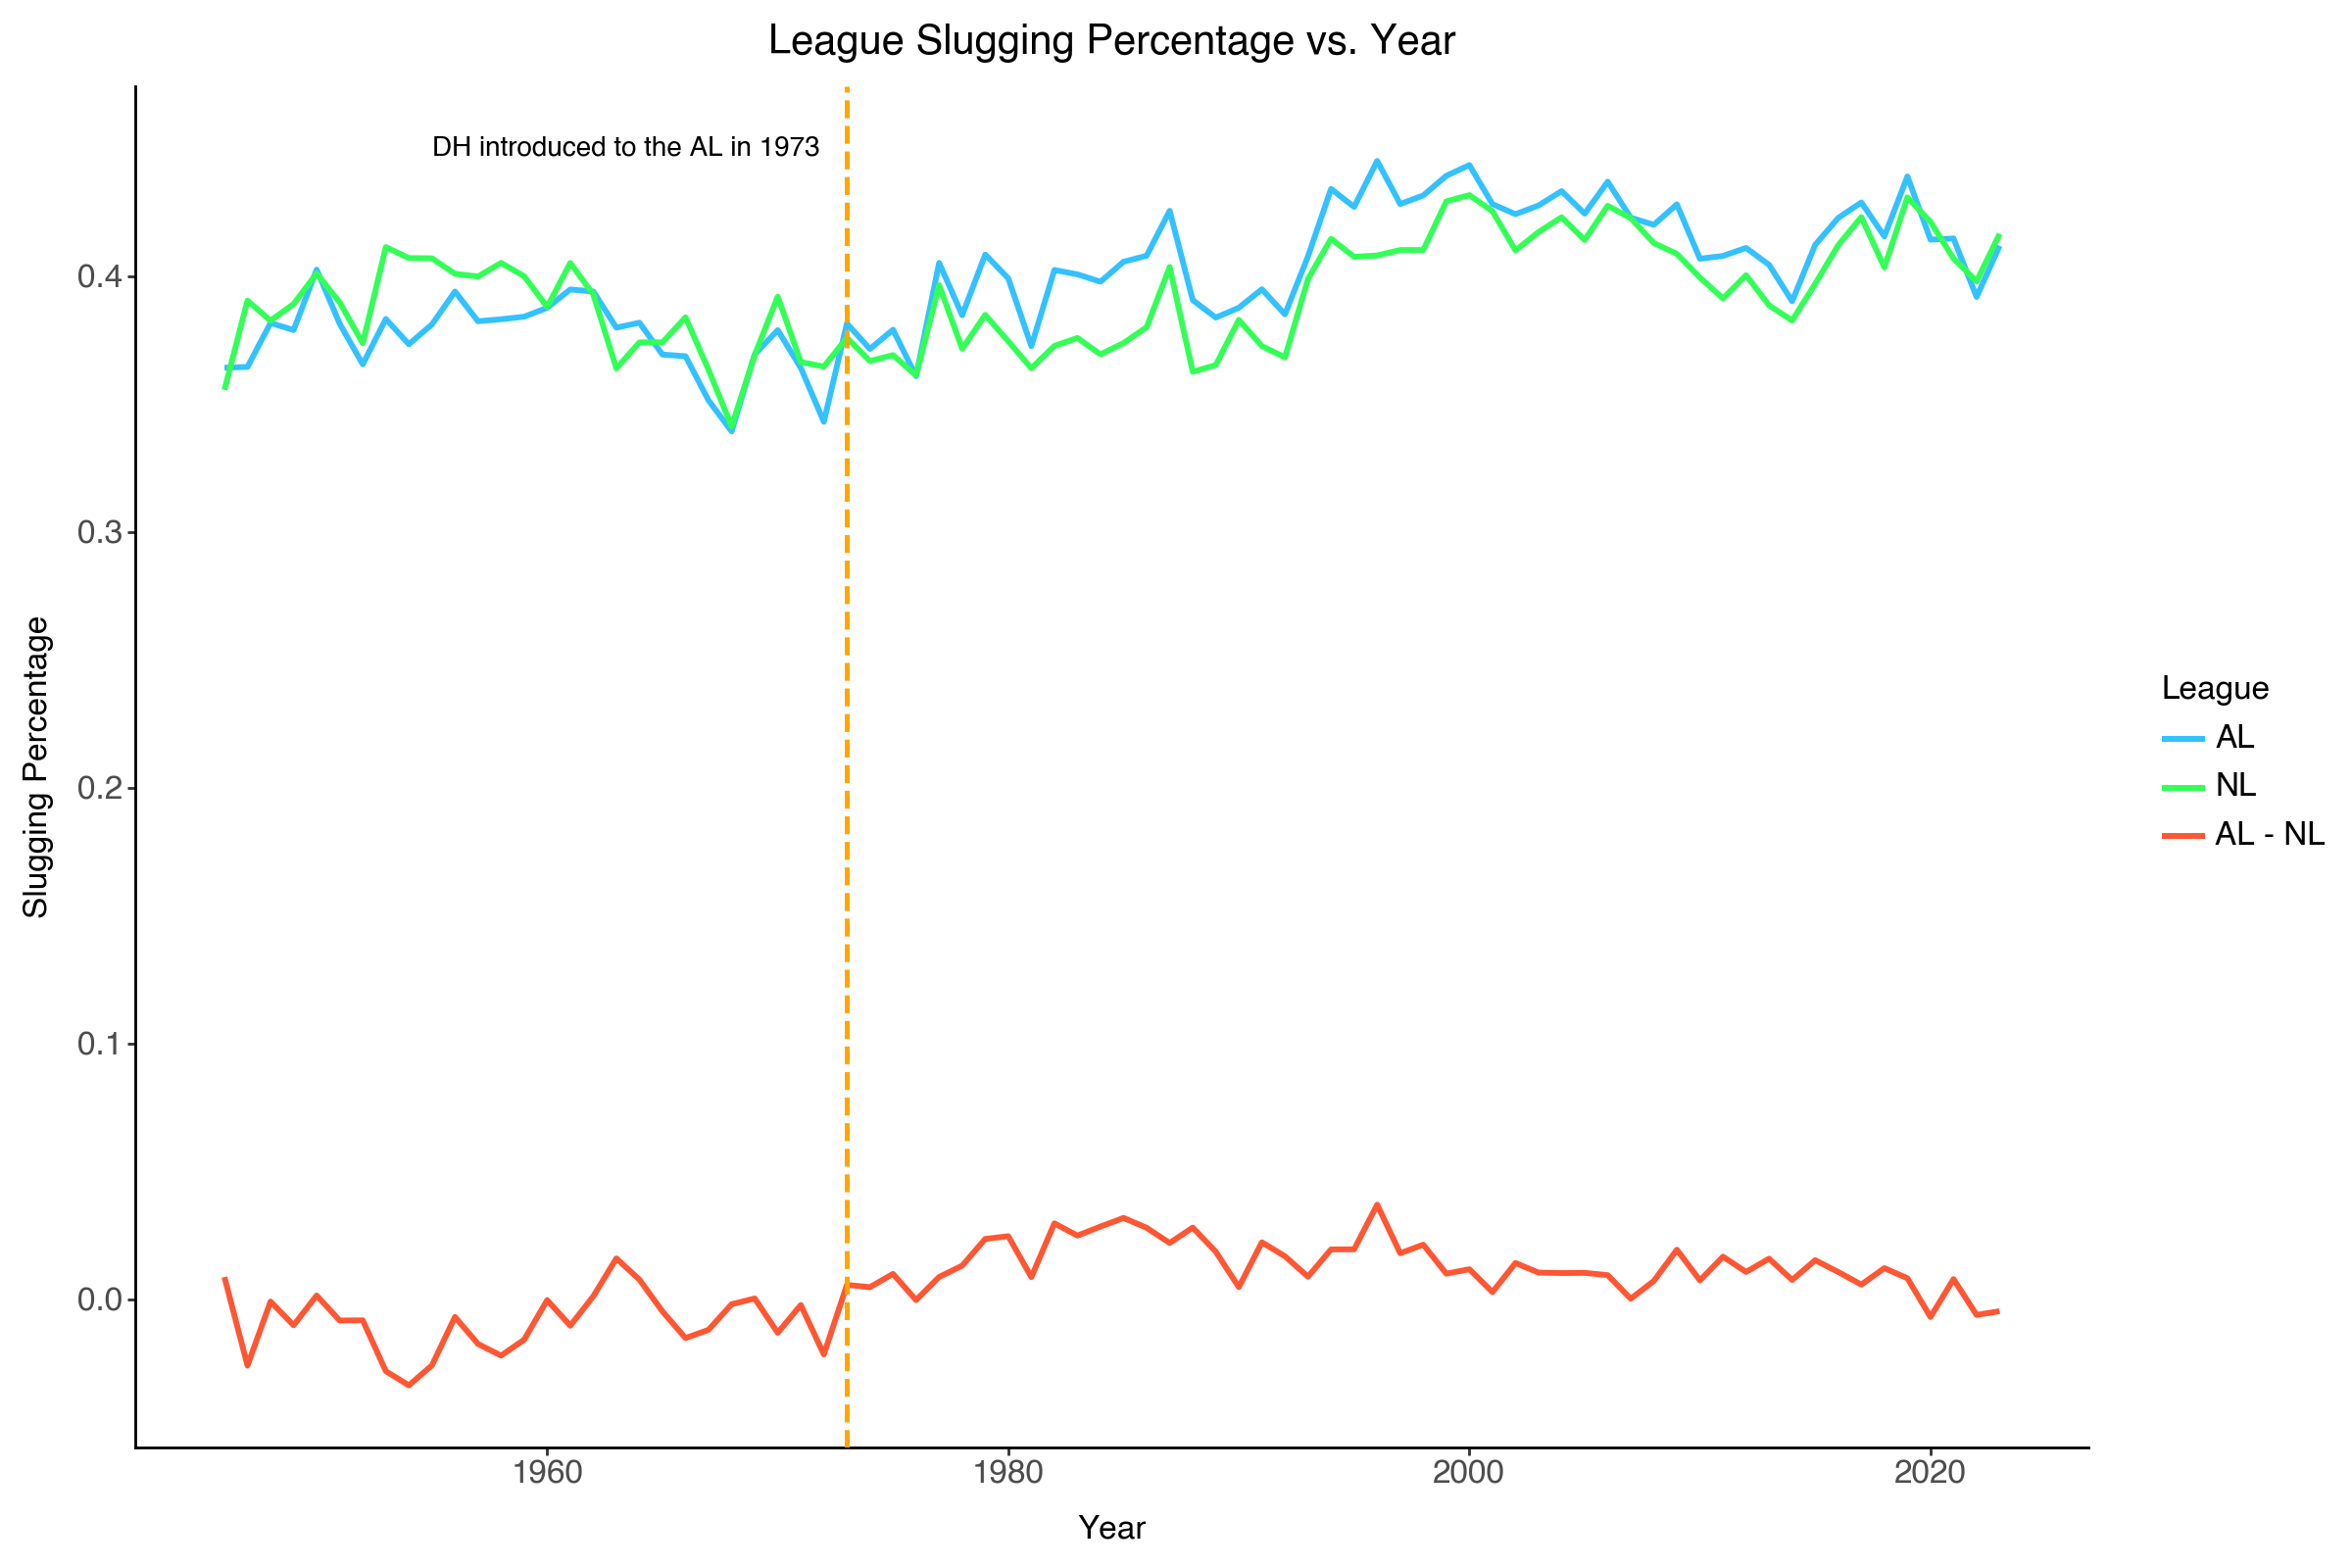

In [73]:
import plotnine as p9

slugging_df = pl.read_csv("./data/lahman_1871-2023_csv/League_Wide_Slugging_Percentage.csv")

slugging_pivot = slugging_df.pivot(index='yearID', columns='lgID', values='Slugging_Percentage')

slugging_pivot = slugging_pivot.with_columns((pl.col('AL') - pl.col('NL')).alias('AL-NL'))

slugging_pivot_pd = slugging_pivot.to_pandas()

slugging_plot = (p9.ggplot(slugging_pivot_pd, p9.aes(x='yearID')) +
    p9.geom_line(p9.aes(y='AL', color='"AL"'), size=1.2) +
    p9.geom_line(p9.aes(y='NL', color='"NL"'), size=1.2) +
    p9.geom_line(p9.aes(y='AL-NL', color='"AL-NL"'), size=1.2) +
    p9.scale_color_manual(values={
        'AL': '#33c1ff',
        'NL': '#33ff57',
        'AL-NL': '#ff5733'
    }, labels=["AL", "NL", "AL - NL"]) +
    p9.labs(title='League Slugging Percentage vs. Year', x='Year', y='Slugging Percentage', color='League') +
    p9.geom_vline(xintercept=1973, linetype='dashed', color='orange', size=1) +
    p9.annotate('text', x=1955, y=0.45, label='DH introduced to the AL in 1973', ha='left', color='black', size=10) +
    p9.theme_classic() +
    p9.theme(legend_position='right', 
          plot_title=p9.element_text(ha='center', size=15),
          text=p9.element_text(size=12)) +
    p9.theme(figure_size=(12, 8))
)

print(slugging_plot)

In [75]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [77]:
from __future__ import braces

SyntaxError: not a chance (3905450354.py, line 1)